<a href="https://colab.research.google.com/github/S-VATS31/Deep_Learning_Models/blob/main/Shaan_Vats_House_Prices_Predictor_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries & Set up CUDA/CPU**

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# **Create a Neural Network Class and Initialize Parameters**

In [2]:
class HousePricesNN(nn.Module):
    def __init__(self, input_size, hidden_layer1, hidden_layer2, hidden_layer3):
        super(HousePricesNN, self).__init__()

        # First Layer (Input Layer)
        self.layer1 = nn.Linear(input_size, hidden_layer1)
        self.relu1 = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(p=0.5)

        # Second Layer (1st Hidden Layer)
        self.layer2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.relu2 = nn.LeakyReLU(0.1)
        self.dropout2 = nn.Dropout(p=0.4)

        # Third Layer (2nd Hidden Layer)
        self.layer3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.relu3 = nn.LeakyReLU(0.1)
        self.dropout3 = nn.Dropout(p=0.3)

        # Fourth Layer (Output Layer)
        self.layer4 = nn.Linear(hidden_layer3, 1)

        # Initialize the weight parameter
        self.apply(self.init_weights_kaiming)

    def init_weights_kaiming(self, layer):
    # Checks if the layer is Linear (dense)
        if isinstance(layer, nn.Linear):
            init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')

        # Checks if the layer has a bias term
            if hasattr(layer, 'bias') and layer.bias is not None:
                nn.init.zeros_(layer.bias) # Initialize bias at 0

    def forward(self, x):
        x = self.relu1(self.layer1(x)) # Input Layer -> 1st Hidden Layer
        x= self.dropout1(x)
        x = self.relu2(self.layer2(x)) # 1st Hidden Layer -> 2nd Hidden Layer
        x= self.dropout2(x)
        x = self.relu3(self.layer3(x)) # 2nd Hidden Layer -> 3rd Hidden Layer
        x= self.dropout3(x)
        x = self.layer4(x) # 3rd Hidden Layer -> Output Layer

        return x


# **Dataset Class**

In [3]:
class CaliforniaHousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    # Return the number of datapoints
    def __len__(self):
        return len(self.X)

    # Return individual instances
    def __getitem__(self, index):
        return self.X[index], self.y[index]

# **Data Preprocessing**

In [4]:
# Fetch data
california_housing = fetch_california_housing()

# Raw data -> DataFrame
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)

# Add target variable
df['Price'] = california_housing.target

# Define X and y
X = df.drop('Price', axis=1).to_numpy()
y = df['Price'].to_numpy()

# Scale X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split into training/testing data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

# Create instances of training and testing dataset
train_dataset = CaliforniaHousingDataset(X_train, y_train)
test_dataset = CaliforniaHousingDataset(X_test, y_test)

# Create instances of training and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=96, shuffle=True)


# **Creating Instances**

In [5]:
torch.manual_seed(42)

# Create an instance of the model
house_prices_nn = HousePricesNN(input_size=8, hidden_layer1=64, hidden_layer2=32, hidden_layer3=16)

# Set up the criterion
criterion = nn.MSELoss()

# Set up optimization algorithm
optimizer = optim.Adam(house_prices_nn.parameters(), lr=0.0011)


# **Model Training & Evaluation Process**

Epoch: 1/1500 - Training Loss: 0.1430, Testing Loss: 0.0819
Epoch: 100/1500 - Training Loss: 0.0124, Testing Loss: 0.0134
Epoch: 200/1500 - Training Loss: 0.0107, Testing Loss: 0.0120
Epoch: 300/1500 - Training Loss: 0.0102, Testing Loss: 0.0116
Epoch: 400/1500 - Training Loss: 0.0097, Testing Loss: 0.0115
Epoch: 500/1500 - Training Loss: 0.0094, Testing Loss: 0.0113
Epoch: 600/1500 - Training Loss: 0.0091, Testing Loss: 0.0111
Epoch: 700/1500 - Training Loss: 0.0088, Testing Loss: 0.0109
Epoch: 800/1500 - Training Loss: 0.0085, Testing Loss: 0.0115
Epoch: 900/1500 - Training Loss: 0.0084, Testing Loss: 0.0110
Epoch: 1000/1500 - Training Loss: 0.0082, Testing Loss: 0.0113
Epoch: 1100/1500 - Training Loss: 0.0082, Testing Loss: 0.0113
Epoch: 1200/1500 - Training Loss: 0.0079, Testing Loss: 0.0112
Epoch: 1300/1500 - Training Loss: 0.0077, Testing Loss: 0.0117
Epoch: 1400/1500 - Training Loss: 0.0077, Testing Loss: 0.0118
Epoch: 1500/1500 - Training Loss: 0.0076, Testing Loss: 0.0111


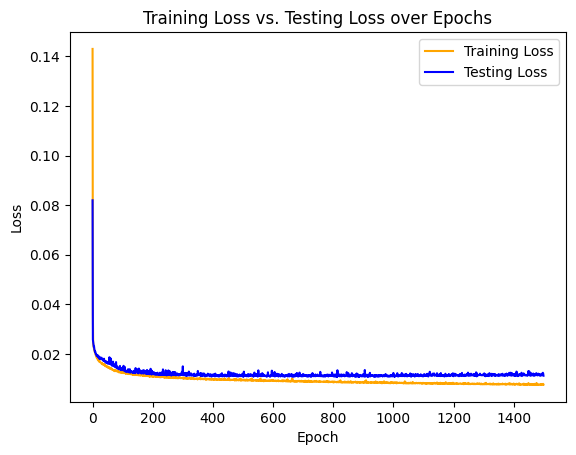

In [6]:
# Function to train and evaluate the model
def train_eval_neural_net(house_prices_nn, criterion, optimizer, train_loader, test_loader, epochs=10000):

    # Make sure house_prices_nn is on the same device
    house_prices_nn.to(device)

    # Set the model to training mode
    house_prices_nn.train()

    # Empty lists to store average losses for plotting
    train_loss_list = []
    test_loss_list = []

    # Global loop
    for epoch in range(epochs):

        # Initialize total train loss
        total_train_loss = 0.0

        # Training-Specific Loop
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            # Turns y_train into a column vector
            y_train = y_train.view(-1, 1)

            optimizer.zero_grad() # Zero the gradients
            y_pred = house_prices_nn(X_train) # Forward pass
            loss = criterion(y_pred, y_train) # Measure loss function
            loss.backward() # Perform backpropagation
            optimizer.step() # Update weights

            total_train_loss += loss.item() # item(): tensor -> scalar

        # Calculate, store, & print training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Set the model to evaluation mode
        house_prices_nn.eval()

        # Initialize total test loss
        total_test_loss = 0.0

        with torch.no_grad(): # Turn off gradient calculation for evaluation mode

            # Testing-Specific Loop
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)

                # Turns y_train into a column vector
                y_test = y_test.view(-1, 1)

                y_pred = house_prices_nn(X_test) # Forward pass
                loss = criterion(y_pred, y_test) # Measure loss function
                total_test_loss += loss.item() # item(): tensor -> scalar

        # Calculate, store, & print testing loss
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_list.append(avg_test_loss)

        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch: {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}")

    # Plot the training loss over epochs
    plt.plot(range(epochs), train_loss_list, label='Training Loss', color='orange')
    plt.plot(range(epochs), test_loss_list, label='Testing Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Testing Loss over Epochs')
    plt.legend()
    plt.show()

# Call training and evaluation function
train_eval_neural_net(house_prices_nn, criterion, optimizer, train_loader, test_loader, epochs=1500)


# **Making Predictions with Trained Model**

In [7]:
# Create a function to evaluate the model on testing data
def eval_test_data(house_prices_nn, test_loader, device):

    # Set the model to evaluation mode
    house_prices_nn.eval()

    # Make sure house_prices_nn is on the same device
    house_prices_nn.to(device)

    # Empty lists to store predictions and true values
    predictions = []
    true_values = []

    with torch.no_grad(): # Turn off gradient calculation for prediction creation
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = house_prices_nn(X_test) # Forward pass

            # Remove dimensions
            if y_pred.dim() > 1 and y_pred.size(1) == 1:
                y_pred = y_pred.squeeze()
            if y_test.dim() > 1 and y_test.size(1) == 1:
                y_test = y_test.squeeze()

            # Convert to numpy arrays and store in CPU
            predictions.append(y_pred.cpu().numpy())
            true_values.append(y_test.cpu().numpy())

    # Concatenate all batches in a large array of values
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)

    return predictions, true_values # Return both predictions and true values

def evaluate_metrics(predictions, true_values):
    # Calculate MAE, RMSE, and R^2
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)

    return mae, rmse, r2

# Call evaluation function
predicted_prices, actual_prices = eval_test_data(house_prices_nn, test_loader, device)

# Calculate metrics function
mae, rmse, r2 = evaluate_metrics(predicted_prices, actual_prices)

# Print predicted vs actual prices for 50 houses
print("Predicted vs Actual Housing Prices:")
for i in range(min(50, len(predicted_prices))):
    print(f"Predicted: ${predicted_prices[i] * 100000:.2f}, Actual: ${actual_prices[i] * 100000:.2f}")

print(f"Mean Absolute Error (MAE): {mae * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R²: {r2:.4f}")


Predicted vs Actual Housing Prices:
Predicted: $39358.86, Actual: $25257.83
Predicted: $43431.48, Actual: $38103.14
Predicted: $30951.23, Actual: $29752.66
Predicted: $37338.89, Actual: $28866.07
Predicted: $32501.49, Actual: $24330.00
Predicted: $8489.84, Actual: $10495.01
Predicted: $57763.25, Actual: $46948.46
Predicted: $39046.71, Actual: $42494.88
Predicted: $37653.12, Actual: $33299.04
Predicted: $11988.25, Actual: $10350.68
Predicted: $38240.50, Actual: $46824.76
Predicted: $19416.95, Actual: $12659.95
Predicted: $41090.75, Actual: $37773.25
Predicted: $24085.03, Actual: $29649.57
Predicted: $39166.71, Actual: $42969.10
Predicted: $36401.09, Actual: $33195.95
Predicted: $24223.06, Actual: $25031.03
Predicted: $27205.21, Actual: $25257.83
Predicted: $49204.11, Actual: $48453.61
Predicted: $47649.86, Actual: $43525.80
Predicted: $48240.25, Actual: $41917.56
Predicted: $78633.87, Actual: $100000.00
Predicted: $21759.84, Actual: $14618.70
Predicted: $44491.42, Actual: $44103.12
Pred